This notebook is used to demonstrate how to probe the relationship between geophysical properties using spatial queries and interpolation. Some parts of this notebook are rather messy as a result of
needing to use data from two different AEM inversions

Neil Symington

neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [48]:
import netCDF4
import pandas as pd
import shapely
import os
from shapely.geometry import Point
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils
from sqlalchemy import create_engine, event

In [3]:
# This function extracts the K profile using the SDR equation

def SDR_K(df, N = 1, C = 2000.):
    '''
    df: dataframe containing GMR inversion data
    N: empirical exponent for water content when estimating the water content
    C: empirical constant for estimating water content
    '''
    return C * df['Total_water_content'].values * df['T2*'].values

In [4]:
# First we will import the AEM conductivity point line data
# The AEM data is in a netCDF file created from a asci files using geophys_utils
# https://github.com/GeoscienceAustralia/geophys_utils


# Load East Kimberley data
infile  = r"C:\Users\PCUser\Desktop\EK_data\AEM\netCDF\EastKimberley_wb_inversion.nc"
ek_cond = netCDF4.Dataset(infile)

# Create an instance of point utils

cond_point_utils = NetCDFPointUtils(ek_cond)

wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

In [5]:
# Summarise the results
print(ek_cond)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    geospatial_east_min: 464605.5
    geospatial_east_max: 565481.375
    geospatial_east_units: m
    geospatial_north_min: 8246242.5
    geospatial_north_max: 8360783.0
    geospatial_north_units: m
    title: Dataset read from ASEG-GDF file EastKimberley_wb_inversion.dat
    Conventions: CF-1.6,ACDD-1.3
    featureType: trajectory
    geospatial_vertical_min: 
    geospatial_vertical_max: 160.4
    geospatial_vertical_units: m
    geospatial_vertical_resolution: point
    geospatial_vertical_positive: up
    history: Converted from ASEG-GDF file C:\Users\PCUser\Desktop\EK_data\AEM\KR_WBsci_smooth03\EastKimberley_wb_inversion.dat using definitions file C:\Users\PCUser\Desktop\EK_data\AEM\KR_WBsci_smooth03\EastKimberley_wb_inversion.dfn
    date_created: 2019-10-01T08:14:48.764618
    geospatial_east_resolution: point
    geospatial_north_resolution: point
    geospatial_bounds: POLYGON((128.9785 -15

In [7]:
# Our next tak is to bring the SNMR data in 

# Connect to the SNMR database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\SNMR\East_Kimberley_SNMR.sqlite"
        
engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

query = """

SELECT
              s.site_id,
              s.Field_ID,
              s.mid_X,
              s.mid_Y,
              a.acquisition_id,
              a.pulse_sequence,
              a.pulse_length,
              imm.Depth_of_Investigation
              
FROM 

             sites as s
             JOIN acquisitions as a on s.site_id=a.site_id
             JOIN inverse_model_metadata as imm on a.acquisition_id = imm.acquisition_id

WHERE

            a.pulse_sequence == "FID"
"""

df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="min")]
df_acquisitions = pd.read_sql_query(query, connection, index_col = 'acquisition_id')

# Since we are interested in the shallow resolution we will use the shorter pulse SNMR


df_acquisitions = df_acquisitions.loc[SNMR_utils.choose_snmr_site_acquisition(df_acquisitions,
                                 pulse_sequence_criteria = ['FID'],
                                 pulse_length_criteria="max")]

# Now extract the SNMR inversions

acquisition_ids = df_acquisitions.index

cols = ['Depth_from', 'Depth_to', 'Mobile_water_content', 'Bound_water_content',
       'Total_water_content', 'T2*', 'acquisition_id', 'inversion_id']

df_SNMR_inversions= SNMR_utils.extract_snmr_inversions(acquisition_ids, connection,
                                                  mask_below_doi = True)[cols]


# Join the SNMR inversions on acquisition and sites

df_SNMR_inversions = df_SNMR_inversions.merge(df_acquisitions, how='inner', left_on='acquisition_id',
                                    right_index=True, )


In [8]:
# Here we get a very rough estimate of K using the Schlumberger Doll equation

df_SNMR_inversions['K'] = SDR_K(df_SNMR_inversions, N = 1, C = 4000)

In [9]:
# Find the nearest neighbours for the 

distances, indices = spatial_functions.nearest_neighbours(df_acquisitions[['mid_X', 'mid_Y']],
                                                         aem_coords, points_required = 1, 
                                                          max_distance = 250.)


In [10]:
# We will save the profiles in a pandas dataframe with a SNMR site key column

df_conductivity = pd.DataFrame(columns = {'acquisition_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity',
                                          'mid_X', 'mid_Y'})

# Iteratively extract the conductivity profiles

for i, (index, row) in enumerate(df_acquisitions.iterrows()):
    
    # This is a check against null which are returned if the nearest neighbour is further
    # than the maximum distance
    if not np.isnan(distances[i]).all():
        
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(ek_cond,
                                                       distances[i],
                                                       indices[i],
                                                       as_dataframe = True)
        # Add the SNMR id to the column
        df_conductivity_profile['acquisition_id'] = index
        
        df_conductivity_profile['mid_X'] = row.mid_X
        
        df_conductivity_profile['mid_Y'] = row.mid_Y
    
        # Append the site profile to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile,
                                                 sort = True)
    
df_conductivity.reset_index(inplace=True, drop=True)

In [11]:
# Iterate through the acquisitions and interpolate the SNMR intervals onto the AEM intervals
# using an average

# Define the columns that are being interpolated 
interpolated_columns = ['Mobile_water_content', 'Bound_water_content', 
                     'Total_water_content', 'K']

interval_columns = ['Depth_from','Depth_to']

for item in interpolated_columns:
    df_conductivity[item] = np.nan

# Iterate through inversions and interpolate them onto a new set of intervals     
for idx in df_acquisitions.index:
    # Define the new intervals based on the conductivity intervals
    mask  = df_conductivity['acquisition_id']==idx
    
    new_intervals = df_conductivity[mask][['Depth_from', 'Depth_to']]
    
    # Extract the inversion data for the site
    mask = df_SNMR_inversions['acquisition_id']==idx
    
    df_inv = df_SNMR_inversions[mask]
    
    # Interpolate and add the interpolated parameter columns to the dataframe
    
    interpolated_SNMR = spatial_functions.interpolate_layered_model(df_inv,
                                                                   interpolated_columns,
                                                                   interval_columns,
                                                                   new_intervals)[interpolated_columns]
    
    df_conductivity.at[new_intervals.index,
                       interpolated_columns] = interpolated_SNMR[interpolated_columns]



In [12]:
df_conductivity

,Depth_from,Depth_to,acquisition_id,conductivity,mid_X,mid_Y,Mobile_water_content,Bound_water_content,Total_water_content,K
0,0.000000,3.0,48,0.081766,499969.9650,8289545.684,0.083426,0.151129,0.234555,315.255537
1,3.000000,6.3,48,0.072516,499969.9650,8289545.684,0.101698,0.162772,0.264470,57.093869
2,6.300000,10.0,48,0.071582,499969.9650,8289545.684,0.074206,0.099306,0.173512,14.854943
3,10.000000,14.1,48,0.068213,499969.9650,8289545.684,0.207844,0.357379,0.565223,49.269410
4,14.100000,18.6,48,0.061690,499969.9650,8289545.684,0.265611,0.410920,0.676531,68.985414
...,...,...,...,...,...,...,...,...,...,...
2659,129.000000,145.7,419,0.174368,500111.1024,8295746.223,0.000000,0.000000,0.000000,0.000000
2660,145.699997,164.2,419,0.198807,500111.1024,8295746.223,0.000000,0.000000,0.000000,0.000000
2661,164.199997,184.6,419,0.221680,500111.1024,8295746.223,0.000000,0.000000,0.000000,0.000000
2662,184.600006,207.2,419,0.219298,500111.1024,8295746.223,0.000000,0.000000,0.000000,0.000000


In [13]:
# Remove columns with zeros for mobile or bound water

mask = (df_conductivity['K'] != 0)

df_conductivity_SNMR = df_conductivity[mask]


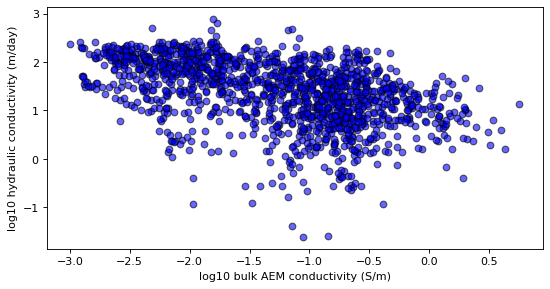

In [14]:
# Lets be specific now
fig, ax = plt.subplots(figsize=(8,4),
                       dpi = 80)
ax.scatter(np.log10(df_conductivity_SNMR['conductivity'].values),
               np.log10(df_conductivity_SNMR['K'].values),
               c='blue',
               alpha=0.6, edgecolors='k')

ax.set_xlabel('log10 bulk AEM conductivity (S/m)')
ax.set_ylabel('log10 hydraulic conductivity (m/day)')    


plt.show()

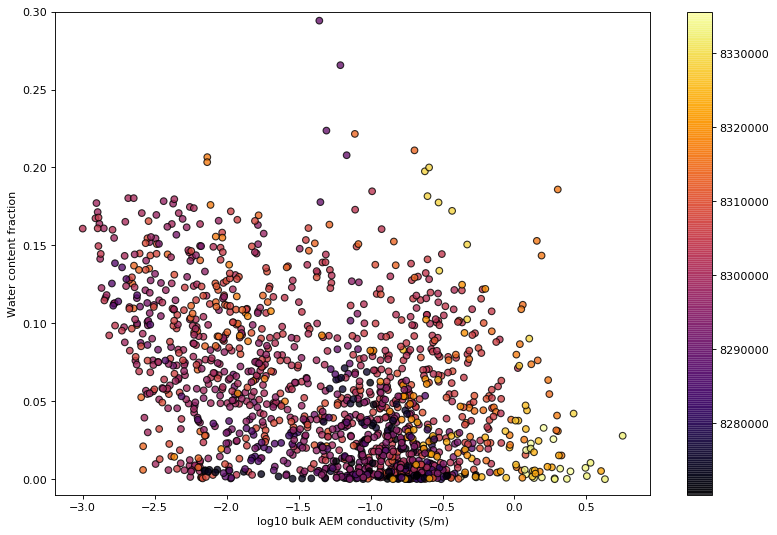

In [15]:
# Lets be specific now
fig, ax = plt.subplots(figsize=(12,8),
                       dpi = 80)

scatter = ax.scatter(np.log10(df_conductivity_SNMR['conductivity'].values),
        (df_conductivity_SNMR['Mobile_water_content'].values),
        c=df_conductivity_SNMR['mid_Y'].values,
           alpha=0.8, edgecolors='k', cmap = 'inferno')

ax.set_xlabel('log10 bulk AEM conductivity (S/m)')
ax.set_ylabel('Water content fraction')    
ax.set_ylim([-0.01,0.3])

colorbar = fig.colorbar(scatter, ax=ax)

plt.show()

In [16]:
# Now lets plot the SNMR porfile on a section

# Create an instance of plots for gridding the data

plots = plotting_utils.ConductivitySectionPlot(ek_cond)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 10., 3.

In [17]:
# Choose a line with a few SNMR sites

lines = [807401]

line = lines[0]

In [18]:
# Grid

gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
                                                 resampling_method = 'linear', save_hdf5 = False, return_dict = True)

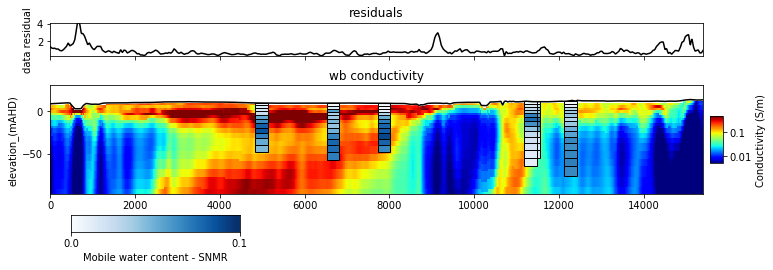

In [62]:
# Panel plotting different inversions

vex = 20.

max_depth = 100.

vmin, vmax = 0.005,0.5

# NOte that the vertical exaggeration and the max depth don't always play nicely
panel_settings = {'panel_1': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'residuals', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  'panel_2': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'wb conductivity',
                                              'max_depth': max_depth, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': vmin, 'vmax': vmax,
                                             'cmap': 'jet', 'ylabel': 'elevation_(mAHD)',
                                             'vertical_exaggeration':vex},
                             'height_ratio': 4}}

# Get ax_array length lists of the panel settings
panel_kwargs  = plot_utils.unpack_plot_settings(panel_settings,
                                             'panel_kwargs')


height_ratios = plot_utils.unpack_plot_settings(panel_settings,
                                                'height_ratio')


# Relative position of the colourbar
x0, y0, width, height = [1.01, 0., 0.02, 1.]

plot_settings = {'vertical_margin': 1.,
                    'panel_vgap': 0.5, 'plot_width': 11.7 #A3 width
                }                        

# Close previous plots
plt.close()

# Intialise figure
fig, ax_array = plt.subplots(len(panel_settings), 1, sharex = True,
                                     gridspec_kw={'height_ratios':
                                                  height_ratios})

res1 = plot_utils.plot_single_line(ax_array[0], gridded_vars[line],
                                   'data_residual', panel_kwargs[0])

ax_array[0].set_title(panel_kwargs[0]['title'])


im1 = plot_utils.plot_grid(ax_array[1], gridded_vars[line], 'conductivity',
                   panel_kwargs[1])

ax_array[1].set_title(panel_kwargs[1]['title'])



# Format the figure to size it for the specified vertical exaggeration
plot_utils.format_panels(ax_array, panel_settings, plot_settings)



# Add colorbars
plot_utils.add_colourbar(fig, ax_array[1], im1, x0, y0, width, height, panel_kwargs[1])

ax_pos = plot_utils.align_axes(ax_array)

# Add axis with northing at the bottom of the plot

# Add the new colourbar for the stick plot
newax = fig.add_axes([0.15,0.02, 0.2, 0.2], anchor='SW', zorder=1)
    
plotting_utils.add_custom_colourbar(newax, cmap, *stretch, "Mobile water content - SNMR")


#plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'],
#                           ax_array[-1], ax_pos[1], offset=-0.4)

#plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'],
#                           ax_array[-1], ax_pos[1], offset=-0.15)

plotting_utils.add_1d_layered_model(ax_array[-1], df_conductivity_SNMR, gridded_vars[line],
                                    plot_variable = 'Mobile_water_content',
                                    xy_columns = ['mid_X', "mid_Y"], cmap = cmap, colour_stretch = stretch,
                                    stick_thickness = 300.)

plt.savefig(r'C:\temp\agc_fig.png', dpi = 300)
plt.show()